In [1]:

import numpy as np
import pandas as pd

from sklearn.model_selection import (
    train_test_split,
    RepeatedStratifiedKFold,
    cross_val_score,
    GridSearchCV
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
from sklearn.base import clone

In [2]:


# -------------------------
# 1) Load + preprocess data
# -------------------------
df = pd.read_csv("data/titanic_augmented.csv")

drop_cols = ["PassengerId", "Name", "Ticket", "Cabin", "booking_reference", "service_id", "title",
             "SibSp", "Parch", "is_alone", "fare_per_person", "age_fare_ratio", "cabin_room_number",
             "name_length", "name_word_count"
             ]
df = df.drop(columns=drop_cols)

# Impute missing values
df["Age"] = df["Age"].fillna(df["Age"].median())
df["Embarked"] = df["Embarked"].fillna(df["Embarked"].mode()[0])

# One-hot encode categoricals
df = pd.get_dummies(
    df,
    columns=["Sex", "Embarked", "title_group", "cabin_deck"],
    drop_first=True
)

X = df.drop(columns=["Survived"])
y = df["Survived"]

# -------------------------
# 2) Train/Test split (25% test)
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

# -------------------------
# 3) Resampling setup (CV on TRAIN only)
# -------------------------
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

# -------------------------
# 4) Baseline LDA model (no tuning)
# -------------------------
baseline_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("lda", LinearDiscriminantAnalysis())  # default solver='svd'
])

cv_scores_baseline = cross_val_score(
    baseline_pipeline, X_train, y_train,
    cv=cv, scoring="accuracy"
)

print("=== Baseline LDA (TRAIN CV) ===")
print(f"CV Accuracy: mean={cv_scores_baseline.mean():.4f}, std={cv_scores_baseline.std():.4f}")

# Fit on TRAIN, evaluate on TEST
baseline_pipeline.fit(X_train, y_train)
y_pred_test = baseline_pipeline.predict(X_test)

print("\n=== Baseline LDA (TEST holdout) ===")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
print(f"Test MSE:      {mean_squared_error(y_test, y_pred_test):.4f}")
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_test))

# -------------------------
# 5) Hyperparameter tuning (TRAIN only) - solver + shrinkage
#    Note: shrinkage applies to lsqr (not svd).
# -------------------------
tuned_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("lda", LinearDiscriminantAnalysis())
])
shrink_grid = ["auto"] + list(np.linspace(0, 1, 21))
param_grid = [
    {"lda__solver": ["svd"]},  # no shrinkage for svd
    {"lda__solver": ["lsqr"], "lda__shrinkage": shrink_grid}
]

grid = GridSearchCV(
    tuned_pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring="accuracy",
    n_jobs=1  # keep 1 for reliability in some notebook environments
)

grid.fit(X_train, y_train)

print("\n=== Tuned LDA (TRAIN CV via GridSearchCV) ===")
print("Best params:", grid.best_params_)
print(f"Best CV Accuracy: {grid.best_score_:.4f}")

best_model = grid.best_estimator_

# Evaluate best tuned model on TEST
y_pred_test_tuned = best_model.predict(X_test)
print("\n=== Tuned LDA (TEST holdout) ===")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_test_tuned):.4f}")
print(f"Test MSE:      {mean_squared_error(y_test, y_pred_test_tuned):.4f}")
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_test_tuned))

# -------------------------
# 6) Feature importance (TRAIN only) using CV-averaged |coefficients|
#    Use a stable LDA config (often shrinkage helps)
# -------------------------
importance_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("lda", LinearDiscriminantAnalysis(solver="lsqr", shrinkage="auto"))
])

coefs = []
for tr_idx, va_idx in cv.split(X_train, y_train):
    X_tr, y_tr = X_train.iloc[tr_idx], y_train.iloc[tr_idx]
    m = clone(importance_pipeline)
    m.fit(X_tr, y_tr)
    coefs.append(m.named_steps["lda"].coef_.ravel())

coefs = np.vstack(coefs)

importance = pd.DataFrame({
    "mean_abs_coef": np.mean(np.abs(coefs), axis=0),
    "std_abs_coef":  np.std(np.abs(coefs), axis=0)
}, index=X_train.columns).sort_values("mean_abs_coef", ascending=False)

print("\n=== Top 15 Features (CV-averaged importance on TRAIN) ===")
print(importance.head(15))

# -------------------------
# 7) Feature tuning: choose top-k features by CV on TRAIN only
# -------------------------
k_results = []
for k in range(5, min(31, X_train.shape[1] + 1)):
    top_k = importance.head(k).index
    X_train_k = X_train[top_k]

    scores_k = cross_val_score(
        importance_pipeline,
        X_train_k,
        y_train,
        cv=cv,
        scoring="accuracy"
    )

    k_results.append({
        "k": k,
        "cv_mean_accuracy": scores_k.mean(),
        "cv_std_accuracy": scores_k.std()
    })

k_results_df = pd.DataFrame(k_results).sort_values("cv_mean_accuracy", ascending=False)
best_k = int(k_results_df.iloc[0]["k"])

print("\n=== Feature Tuning Results (TRAIN CV) ===")
print("Best k by CV mean accuracy:", best_k)
print(k_results_df.head(10))

# -------------------------
# 8) Final feature-tuned model: fit on TRAIN, evaluate on TEST
# -------------------------
final_features = importance.head(best_k).index
final_model = Pipeline([
    ("scaler", StandardScaler()),
    ("lda", LinearDiscriminantAnalysis(solver="lsqr", shrinkage="auto"))
])

final_model.fit(X_train[final_features], y_train)
y_pred_final = final_model.predict(X_test[final_features])

print("\n=== Final Feature-Tuned LDA (TEST holdout) ===")
print("Using top-k features:", best_k)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_final):.4f}")
print(f"Test MSE:      {mean_squared_error(y_test, y_pred_final):.4f}")
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_final))

=== Baseline LDA (TRAIN CV) ===
CV Accuracy: mean=0.8239, std=0.0441

=== Baseline LDA (TEST holdout) ===
Test Accuracy: 0.8386
Test MSE:      0.1614
Confusion matrix:
 [[120  17]
 [ 19  67]]

=== Tuned LDA (TRAIN CV via GridSearchCV) ===
Best params: {'lda__solver': 'svd'}
Best CV Accuracy: 0.8239

=== Tuned LDA (TEST holdout) ===
Test Accuracy: 0.8386
Test MSE:      0.1614
Confusion matrix:
 [[120  17]
 [ 19  67]]

=== Top 15 Features (CV-averaged importance on TRAIN) ===
                    mean_abs_coef  std_abs_coef
title_group_Mr           1.116917      0.054673
Sex_male                 0.752968      0.053789
Pclass                   0.570458      0.038568
title_group_Mrs          0.458848      0.035840
Age                      0.453236      0.038803
cabin_deck_Unknown       0.414180      0.034241
cabin_deck_D             0.296378      0.035102
Fare                     0.283729      0.033477
family_size              0.275960      0.038642
title_group_Miss         0.262100      0.

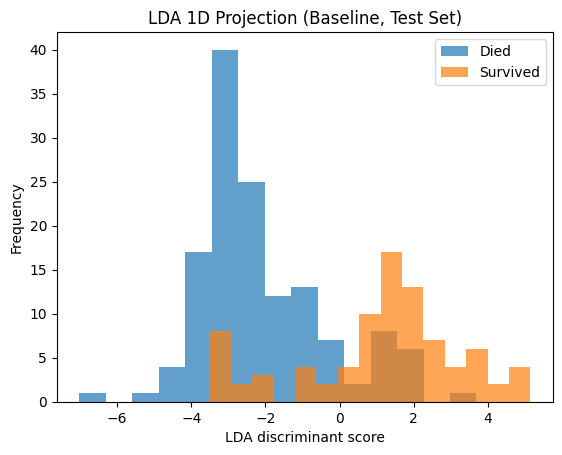

In [3]:
import matplotlib.pyplot as plt

baseline_pipeline.fit(X_train, y_train)

lda_scores = baseline_pipeline.decision_function(X_test)

plt.figure()
plt.hist(lda_scores[y_test == 0], bins=15, alpha=0.7, label="Died")
plt.hist(lda_scores[y_test == 1], bins=15, alpha=0.7, label="Survived")
plt.xlabel("LDA discriminant score")
plt.ylabel("Frequency")
plt.title("LDA 1D Projection (Baseline, Test Set)")
plt.legend()
plt.show()

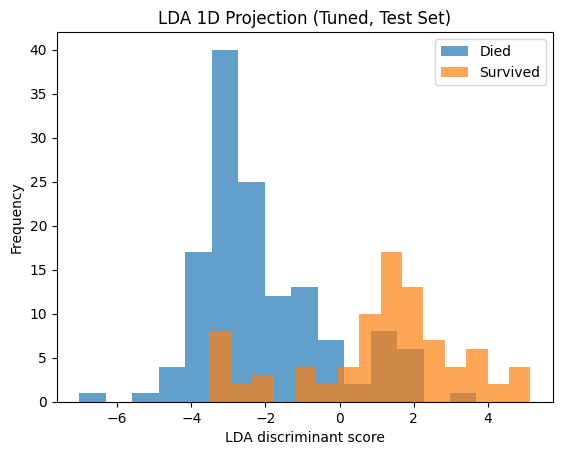

In [8]:
import matplotlib.pyplot as plt

best_model.fit(X_train, y_train)

lda_scores = best_model.decision_function(X_test)

plt.figure()
plt.hist(lda_scores[y_test == 0], bins=15, alpha=0.7, label="Died")
plt.hist(lda_scores[y_test == 1], bins=15, alpha=0.7, label="Survived")
plt.xlabel("LDA discriminant score")
plt.ylabel("Frequency")
plt.title("LDA 1D Projection (Tuned, Test Set)")
plt.legend()
plt.show()

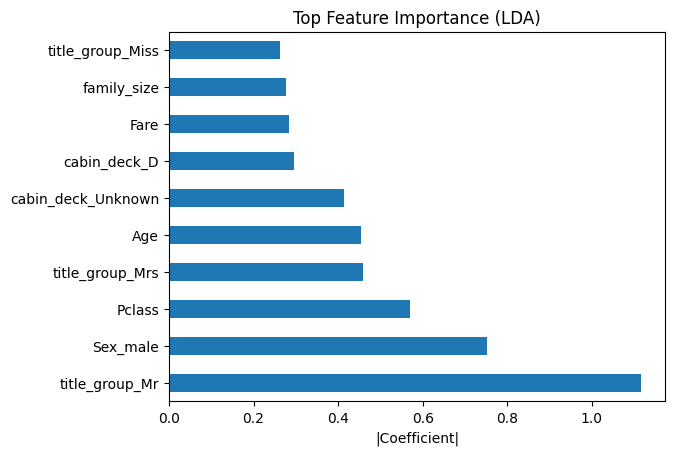

In [5]:
importance.head(10)["mean_abs_coef"].plot(kind="barh")
plt.title("Top Feature Importance (LDA)")
plt.xlabel("|Coefficient|")
plt.show()

##

## Methodology

### Data Preprocessing

The titantic dataset was preprocessed to enhance its suitability for statistical modeling and to reduce noise and redundancy. Identifer features lacking predictive relevance, such as passenger identifers or ticket numbers, were removed prior to analysis. Missing values in numeric features were imputed using the median, whereas missing categorical variables were imputed using the mode. Categorical features were encoded as dummy variables to use in linear modeling frameworks. 

To further reduce redundancy and limit multicollinearity, several features were evaluated and pruned. For example, family-related variables were replaced with a single family size variable. This step is necessary for Linear Discriminant Analysis (LDA) since this method relies on covariance estimation and is sensitive to highy correlated inputs. 

### Model Selection

#### Linear Discriminant Analysis

LDA is one of the methods selected due to its interpertability and effectiveness in classification settings involving structured tabular data. LDA identifies a linear combination of features that maximizes seperation between classes while assuming a shared covariance, an approach orginally indtroduced by Fisher (1936) and later formalized

## References
References

Fisher, R. A. (1936). The use of multiple measurements in taxonomic problems. Annals of Eugenics, 7(2), 179–188.

Géron, A. (2022). Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow (3rd ed.). O’Reilly Media.

Hastie, T., Tibshirani, R., & Friedman, J. (2009). The Elements of Statistical Learning (2nd ed.). Springer.

James, G., Witten, D., Hastie, T., & Tibshirani, R. (2021). An Introduction to Statistical Learning with Applications in R (2nd ed.). Springer.

<!-- Kohavi, R. (1995). A study of cross-validation and bootstrap for accuracy estimation and model selection. Proceedings of the 14th International Joint Conference on Artificial Intelligence.

Kuhn, M., & Johnson, K. (2013). Applied Predictive Modeling. Springer.

Ledoit, O., & Wolf, M. (2004). A well-conditioned estimator for large-dimensional covariance matrices. Journal of Multivariate Analysis, 88(2), 365–411.

Pedregosa, F., et al. (2011). Scikit-learn: Machine learning in Python. Journal of Machine Learning Research, 12, 2825–2830. -->
